In [ ]:
# !pip install langchain langgraph cassio langchain_community tiktoken langchain-groq langchainhub langchain_huggingface arxiv wikipedia python-dotenv

In [30]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [31]:
import cassio
# connection of Astra DB
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id = ASTRA_DB_ID
)

In [ ]:
# Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://www.loveandlemons.com/brownies-recipe/",
    "https://www.allrecipes.com/recipe/17481/simple-white-cake/",
    "https://pinchofyum.com/the-best-soft-chocolate-chip-cookies"
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
print(doc_list)

# traditional way
# text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)

# using tiktoken
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 500, chunk_overlap = 0)

docs_split = text_splitter.split_documents(doc_list)

[Document(metadata={'source': 'https://www.loveandlemons.com/brownies-recipe/', 'title': 'Best Homemade Brownies Recipe - Love and Lemons', 'description': 'The best brownie recipe! Made with cocoa powder and chocolate chips, these homemade brownies are fudgy, gooey, super chocolaty, and easy to make!', 'language': 'en-US'}, page_content="Best Homemade Brownies Recipe - Love and Lemons\n                 \n   \n    \nRECIPESABOUTNEWSLETTERCOOKBOOKSAVED RECIPES\n\n\n\n\nNavigation\nHome\nAbout Us\nRecipes\nMy Saved Recipes\nCookbook\nNewsletter\nContact\n\n\nGo!Social\nInstagram\nFacebook\nPinterest\nTwitter  \n\nBest Homemade BrowniesThe BEST brownie recipe! With crispy edges, fudgy middles, and rich chocolate flavor, these homemade brownies will disappear in no time.\nvegetarian — Jump to recipe\n\n\n\n\n\nFor years, I couldn’t seem to find a recipe for brownies that met my standards. Anytime I made homemade brownies, I wanted them to be just like the ones I ate as a kid – super fudgy, 

In [33]:
docs_split

[Document(metadata={'source': 'https://www.loveandlemons.com/brownies-recipe/', 'title': 'Best Homemade Brownies Recipe - Love and Lemons', 'description': 'The best brownie recipe! Made with cocoa powder and chocolate chips, these homemade brownies are fudgy, gooey, super chocolaty, and easy to make!', 'language': 'en-US'}, page_content='Best Homemade Brownies Recipe - Love and Lemons\n                 \n   \n    \nRECIPESABOUTNEWSLETTERCOOKBOOKSAVED RECIPES\n\n\n\n\nNavigation\nHome\nAbout Us\nRecipes\nMy Saved Recipes\nCookbook\nNewsletter\nContact\n\n\nGo!Social\nInstagram\nFacebook\nPinterest\nTwitter  \n\nBest Homemade BrowniesThe BEST brownie recipe! With crispy edges, fudgy middles, and rich chocolate flavor, these homemade brownies will disappear in no time.\nvegetarian — Jump to recipe'),
 Document(metadata={'source': 'https://www.loveandlemons.com/brownies-recipe/', 'title': 'Best Homemade Brownies Recipe - Love and Lemons', 'description': 'The best brownie recipe! Made with 

In [34]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [35]:
from langchain.vectorstores import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name = "CNM_test_table",
                               session=None,
                               keyspace=None)

In [36]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)
print(f"Inserted {len(docs_split)} headlines")
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 56 headlines


In [ ]:
retriever = astra_vector_store.as_retriever()
retriever.invoke("Give me a cookie recipe")

[Document(id='53874fa27eca451281e0084ab85c34f3', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-soft-chocolate-chip-cookies', 'title': 'The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum'}, page_content='Me \nLindsay was kind enough to post this perfect recipe. I think you can figure this one out yourself‚Ä¶ Smh\n\n\n\n04/21/16 @ 8:56 pm\n\n\nReply \n\n\n\n\n\n\n \n\n\n\nhoi \nYah, toats agree vith Zou!\n \n\n04/30/16 @ 10:00 am\n\n\n\n\n\n\n\n\n\n \n\n\n\nKevin \nMaybe you shouldn‚Äôt be so weirdly hateful in the comments section of a yummy chocolate chip cookies recipe? This is supposed to be fun, right?\n\n\n\n12/24/16 @ 9:30 pm\n\n\n\n\n\n\n\n\n\n \n\n\n\njacquelyn karney \nIf you are making chocolate chip cookies, who cares about the nutritional information?\n \n\n06/15/19 @ 11:36 pm\n\n\n\n\n\n\n\n\n\n \

In [38]:
# langgraph application
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser


In [39]:
# Data model
class RouteQuery(BaseModel):
  """Route a user query to the most relevant datasource"""
  datasource: Literal["vectorstore","wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore"
  )

In [40]:
from langchain_groq import ChatGroq
# from google.colab import userdata
import os
groq_api_key = os.getenv('groq_api_key')
# print(groq_api_key)

In [41]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000249372ADF90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000249372DBE50>, model_name='Llama-3.3-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [42]:
structured_llm_router=llm.with_structured_output(RouteQuery)

In [ ]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to baking.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "what is stardew Valley"}
    )
)
print(question_router.invoke({"question": "How to make a sweet dessert"}))

datasource='wiki_search'
datasource='vectorstore'


In [44]:
# summarize Prompt
summarize_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {documents}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "documents"],
)

summarize_chain = summarize_prompt | llm | StrOutputParser()

In [45]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)


In [46]:
wiki.run("crab")

'Page: Crab\nSummary: Crabs are decapod crustaceans of the infraorder Brachyura (meaning "short tail" in Greek), which typically have a very short projecting tail-like abdomen, usually hidden entirely under the thorax. They live in all the world\'s oceans, in freshwater, and on land. They are generally covered with a thick exoskeleton. They generally have five pairs of legs, and they have pincer claws on the ends of the frontmost pair. They first appeared during the Jurassic period, around 200 mill'

In [47]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [ ]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [49]:
def generate(state):
    """
    Generate LLM response

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # Generate
    generation = summarize_chain.invoke({"question": question, "documents": documents})
    return {"generation": generation, "question": question, "documents": documents}

In [50]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [51]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [52]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", "generate")
workflow.add_edge( "generate",END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

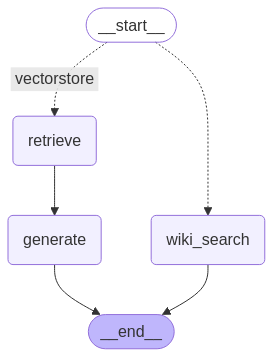

In [53]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
from pprint import pprint

# Run
inputs = {
    "question": "What is how to bake a cookie?"
}
config = {"configurable":{"thread_id":"1"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])
pprint(value['generation'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('These are THE BEST soft chocolate chip cookies! No chilling required. Just '
 'ultra thick, soft, classic chocolate chip cookies!')
('To bake a cookie, preheat the oven to 350 degrees, then mix the ingredients '
 'and roll the dough into balls. Place the balls on a cookie sheet and bake '
 'for 9-11 minutes until they look puffy and dry. Let them cool on the pan for '
 '30 minutes to achieve dense, buttery, and soft cookies.')


C:\Users\Ashwin Raja\AppData\Local\Temp\ipykernel_16840\2229243983.py:17: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [55]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Avengers
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Avengers: Endgame\nSummary: Avengers: Endgame is a 2019 American superhero film based on the Marvel Comics superhero team the Avengers. Produced by Marvel Studios and distributed by Walt Disney Studios Motion Pictures, it is the direct sequel to Avengers: Infinity War (2018) and the 22nd film in the Marvel Cinematic Universe (MCU). Directed by Anthony and Joe Russo and written by Christopher Markus and Stephen McFeely, the film features an ensemble cast which includes Robert Downey Jr., Chr')
